In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Read in dataset
sample_data_2021 = pd.read_csv('/content/drive/MyDrive/DSA4264My/sample_2021.csv')
sample_data_2223 = pd.read_csv('/content/drive/MyDrive/DSA4264My/sample_2223.csv')

In [ ]:
# Change to list
texts_2021 = sample_data_2021['text'].tolist()
texts_2223 = sample_data_2223['text'].tolist()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest").to(device)

In [ ]:
# Roberta Sentiment Model with Truncation
def roberta_sentiment(texts, max_length=512, batch_size=128):
    results = []
    total_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate total batches

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize the batch of texts
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
            logits = outputs.logits

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=1)
            predicted_classes = torch.argmax(logits, dim=1).tolist()
            confidence_scores = probabilities.max(dim=1).values.tolist()

            # Map predicted class to sentiment label
            sentiment_labels = ["negative", "neutral", "positive"]
            batch_results = [
                {'Sentiment': sentiment_labels[predicted_class], 'Confidence': confidence_score}
                for predicted_class, confidence_score in zip(predicted_classes, confidence_scores)
            ]

            results.extend(batch_results)

    return results

In [ ]:
# Small sample test run
sample_data = texts_2021[:20]
sentiment_results_sample = roberta_sentiment(sample_data)
print(sentiment_results_sample)
print(sample_data[0])

In [ ]:
# Run the sentiment analysis on the 2021 dataset
sentiment_results_2021 = roberta_sentiment(texts_2021)
sentiment_df_2021 = pd.DataFrame(sentiment_results_2021, columns=['Sentiment'])
sentiment_df_2021.to_csv('/content/drive/MyDrive/DSA4264My/sentiment_2021.csv', mode='a', header=False, index=False)

In [ ]:
# Create a DataFrame to hold month, year, and sentiment for 2021 dataset
combined_results_2021 = sample_data_2021[['month', 'year']].copy()  # Use the original DataFrame
combined_results_2021['Sentiment'] = sentiment_df_2021['Sentiment']  # Add the sentiment results
combined_results_2021.to_csv('/content/drive/MyDrive/DSA4264My/combined_results_2021.csv', index=False)

In [ ]:
# Run sentiment analysis on the 2223 dataset
sentiment_results_2223 = roberta_sentiment(texts_2223)
sentiment_df_2223 = pd.DataFrame(sentiment_results_2223, columns=['Sentiment'])
sentiment_df_2223.to_csv('/content/drive/MyDrive/DSA4264My/sentiment_2223.csv', mode='a', header=False, index=False)

In [ ]:
# Create a DataFrame to hold month, year, and sentiment for 2223 dataset
combined_results_2223 = sample_data_2223[['month', 'year']].copy()  # Use the original DataFrame
combined_results_2223['Sentiment'] = sentiment_df_2223['Sentiment']  # Add the sentiment results
combined_results_2223.to_csv('/content/drive/MyDrive/DSA4264My/combined_results_2223.csv', index=False)

In [4]:
# Preparing data for visualizations
data_2021 = pd.read_csv('/content/drive/MyDrive/DSA4264My/combined_results_2021.csv')
data_2223 = pd.read_csv('/content/drive/MyDrive/DSA4264My/combined_results_2223.csv')

# Ensure the 'month' and 'year' columns are in integer format
data_2021['month'] = data_2021['month'].astype(int)
data_2021['year'] = data_2021['year'].astype(int)

data_2223['month'] = data_2223['month'].astype(int)
data_2223['year'] = data_2223['year'].astype(int)

In [5]:
# Concatenate the two data files
combined_data = pd.concat([data_2021[['year', 'month', 'Sentiment']], data_2223[['year', 'month', 'Sentiment']]])

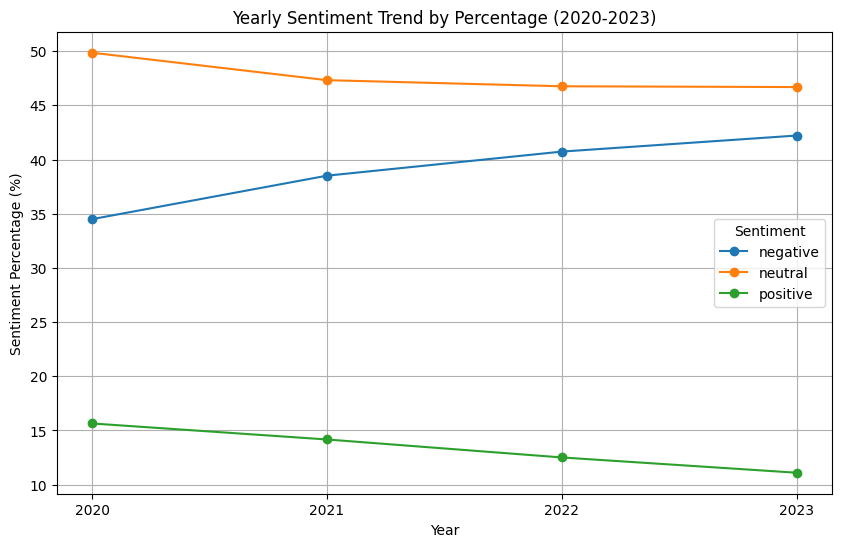

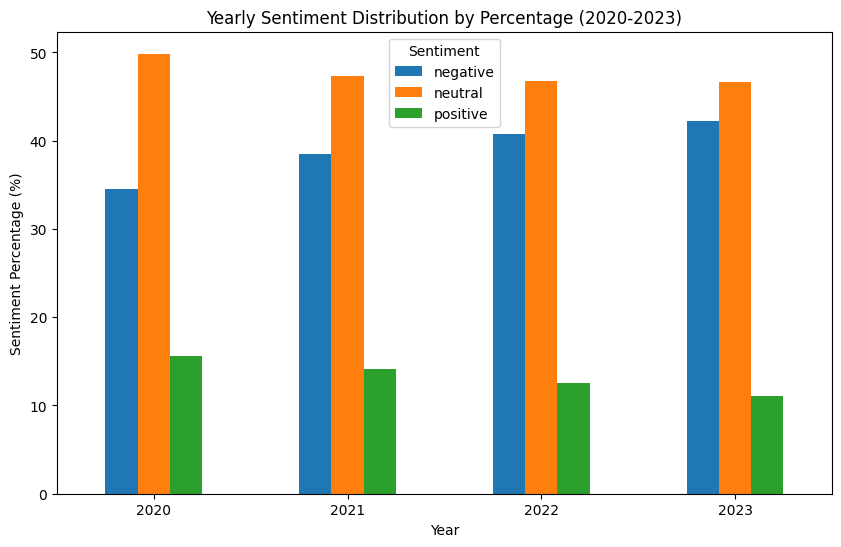

In [18]:
import matplotlib.pyplot as plt

# Normalize to percentages
yearly_sentiment_percentages = yearly_sentiment.div(yearly_sentiment_counts.sum(axis=1), axis=0) * 100

# Plot Line Graph for Yearly Sentiment Percentage Trends
yearly_sentiment_percentages.plot(kind='line', marker='o', figsize=(10, 6), title='Yearly Sentiment Trend by Percentage (2020-2023)')
plt.xlabel("Year")
plt.ylabel("Sentiment Percentage (%)")
plt.xticks(yearly_sentiment_percentages.index)  # Display only years on x-axis
plt.grid()
plt.legend(title="Sentiment")
plt.show()

# Plot Normal Bar Graph for Yearly Sentiment Percentage Distribution
yearly_sentiment_percentages.plot(kind='bar', figsize=(10, 6), title='Yearly Sentiment Distribution by Percentage (2020-2023)')
plt.xlabel("Year")
plt.ylabel("Sentiment Percentage (%)")
plt.xticks(rotation=0)  # Keep x-axis labels (years) horizontal
plt.legend(title="Sentiment")
plt.show()


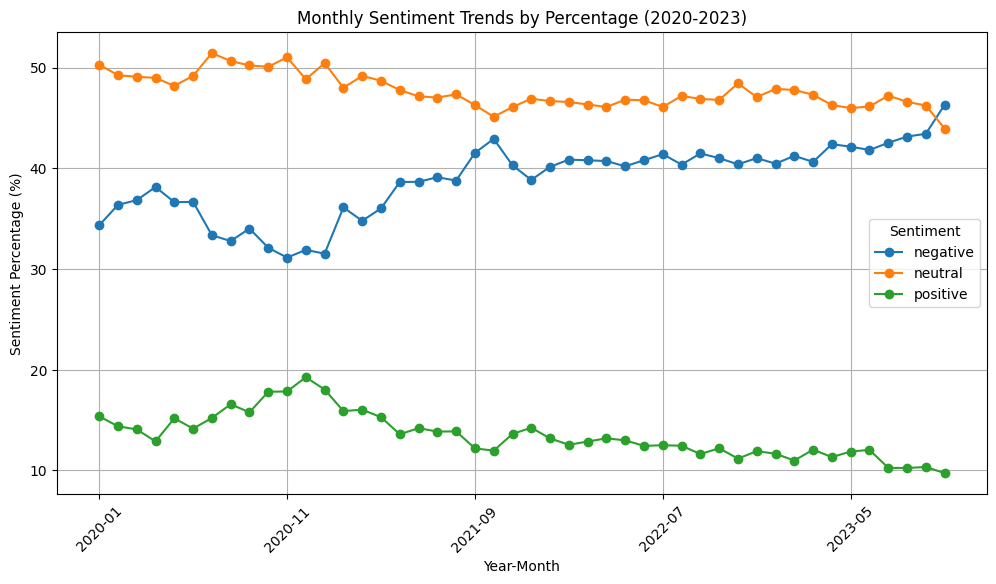

In [22]:
# Normalize to percentage
monthly_sentiment_percentages = monthly_sentiment_counts.div(monthly_sentiment.sum(axis=1), axis=0) * 100
monthly_sentiment_percentages.index = [f"{int(year)}-{int(month):02d}" for year, month in monthly_sentiment_percentages.index]

# Monthly Sentiment Line Graph
monthly_sentiment_percentages.plot(kind='line', figsize=(12, 6), marker='o', title='Monthly Sentiment Trends by Percentage (2020-2023)')
plt.xlabel("Year-Month")
plt.ylabel("Sentiment Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid()
plt.show()
